In [1]:
import pandas as pd

In [2]:
geno_bed = pd.read_table('~/data/IMPORTANT_genome/arabidopsis/tair10/all_chr.bed',header=None,names=['chrom','chr_start','chr_end'])

# order 2 

In [68]:
geno_file = '~/data/IMPORTANT_genome/arabidopsis/tair10/all_chr.bed'
contact_file = '/public/home/lizw/task/pore_c/porec_1000_filter_mainchr_result/porecplot_v3/porec_pre_v2.9/DpnII_run08.order_2_merge_part.parquet'
singleton_file = '/public/home/lizw/task/pore_c/porec_1000_filter_mainchr_result/porecplot_v3/porec_pre_v2.9/DpnII_run07.order_2_sorted_singleton_fornormailize.parquet'

In [69]:
def contact_nor(contact_file,singleton_file,geno_file,prefix):
    geno_bed = pd.read_table(geno_file,header=None,names=['chrom','chr_start','chr_end'])
    contact_table = pd.read_parquet(contact_file)
    contact_table['chrom_int'] = [int(x) for x in contact_table['chrom']]
    singleton_table = pd.read_parquet(singleton_file)
    singleton_table['chrom_int'] = [int(x) for x in singleton_table['chrom']]
    binsize = 100

    interval_Ser = pd.Series([])
    for i in contact_table.groupby(by='chrom_int'):
        chrom,df = i
        chr_start = 0
        chr_end = geno_bed.loc[int(chrom)-1,'chr_end']
        df_cut = pd.cut(df['pos'],bins=np.arange(chr_start,chr_end+binsize,binsize),right=False)
        interval_Ser = interval_Ser.append(df_cut)

    interval_Ser.name = 'interval'
    contact_table = pd.merge(contact_table,interval_Ser,left_index=True,right_index=True)
    contact_table['start']  = [int(x.left) for x in contact_table['interval']]
    contact_table['end'] = [int(x.right) for x in contact_table['interval']]

    interval_Ser = pd.Series([])
    for i in singleton_table.groupby(by='chrom_int'):
        chrom,df = i
        chr_start = 0
        chr_end = geno_bed.loc[int(chrom)-1,'chr_end']
        df_cut = pd.cut(df['pos'],bins=np.arange(chr_start,chr_end+binsize,binsize),right=False)
        interval_Ser = interval_Ser.append(df_cut)

    interval_Ser.name = 'interval'
    singleton_table = pd.merge(singleton_table,interval_Ser,left_index=True,right_index=True)
    singleton_table['start']  = [int(x.left) for x in singleton_table['interval']]
    singleton_table['end'] = [int(x.right) for x in singleton_table['interval']]

    contact_size = contact_table.groupby(by=['chrom_int','interval']).size()
    single_size = singleton_table.groupby(by=['chrom_int','interval']).size()
    contact_size.name = 'contact'
    single_size.name='singleton'
    merge = pd.merge(contact_size,single_size,on=['chrom_int','interval'])
    merge.eval('binnor = contact/singleton',inplace=True)
    merge = merge.assign(binnor_nor = lambda df:df['binnor']/df['binnor'].max())
    merge = merge.reset_index(level=[0,1])
    merge['start']  = [int(x.left) for x in merge['interval']]
    merge['end'] = [int(x.right) for x in merge['interval']]
    merge.reindex(['chrom_int','start','end','binnor_nor'],axis=1).to_csv(f'/public/home/lizw/task/pore_c/methylation/{prefix}bedgraph',sep='\t',header=None,index=None)
    return merge

In [ ]:
merge = contact_nor(contact_file,singleton_file,geno_file,'contact_100')

In [54]:
met_table_100 = pd.read_table('/public/home/lizw/task/pore_c/methylation/LongC_rep2.bedgraph',header=None,names=['chrom_int','start','end','met'])

In [60]:
contact_met = pd.merge(merge,met_table_100,on=['chrom_int','start','end'],how='outer').dropna()

In [62]:
def consistency(object1,object2,label1,label2,kind):
    import matplotlib.pyplot as plt
    import matplotlib.font_manager as font_manager
    font_dirs = ["/public/home/lizw/software/font"]
    font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
    for font_file in font_files:
        font_manager.fontManager.addfont(font_file)
    plt.rcParams["font.family"] = "Arial"
    plt.rcParams["font.size"] = 30
    
    fig, ax = plt.subplots(1,figsize=(10,10))
    plt.scatter(object1,object2,s=2,color='orange')
    scalemax = max(object1.max(),object2.max())
    scalemin = min(object1.min(),object2.min())
    plt.plot((scalemin,scalemax), (scalemin, scalemax), ls='--',c='k')
    plt.xlim(scalemin,scalemax)
    plt.ylim(scalemin,scalemax)
    plt.xlabel(f'{label1}')
    plt.ylabel(f'{label2}')
    r = object1.corr(object2)
    plt.text(scalemin+(scalemax-scalemin)/5,scalemax+(scalemax-scalemin)/20,f'Pearson r {r}')
    plt.axis('equal')
    plt.savefig(f'/public/home/lizw/task/pore_c/methylation/{label1}_{label2}_{kind}.png',format='png',dpi=300,bbox_inches = 'tight')

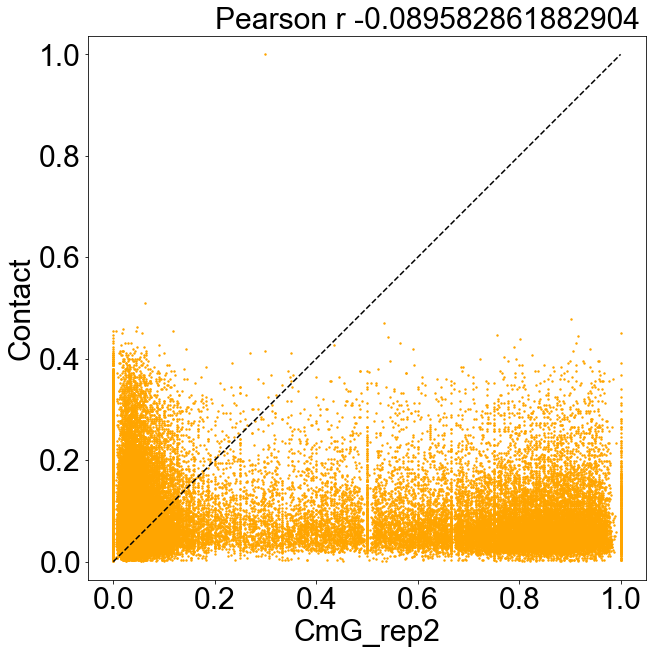

In [63]:
consistency(contact_met['met'],contact_met['binnor_nor'],'CmG_rep2','Contact','_')

# order 5 

In [76]:
contact_file_order5 = '/public/home/lizw/task/pore_c/porec_1000_filter_mainchr_result/porecplot_v3/order5/DpnII_run08.order_5_merge_part.parquet'
singleton_file_order5 = '/public/home/lizw/task/pore_c/porec_1000_filter_mainchr_result/porecplot_v3/order5/DpnII_run08.order_5_sorted_orderall_fornormailize.parquet'

In [77]:
merge_order5 = contact_nor(contact_file_order5,singleton_file_order5,geno_file,'order5_contact_100')

/public/home/lizw/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  if __name__ == '__main__':
/public/home/lizw/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


In [78]:
merge_order5

,chrom_int,interval,contact,singleton,binnor,binnor_nor,start,end
0,1,"[100, 200)",32,53,0.603774,0.603774,100,200
1,1,"[600, 700)",56,100,0.560000,0.560000,600,700
2,1,"[1100, 1200)",43,73,0.589041,0.589041,1100,1200
3,1,"[1300, 1400)",9,20,0.450000,0.450000,1300,1400
4,1,"[1600, 1700)",52,78,0.666667,0.666667,1600,1700
...,...,...,...,...,...,...,...,...
342213,5,"[26973100, 26973200)",22,32,0.687500,0.687500,26973100,26973200
342214,5,"[26973400, 26973500)",41,88,0.465909,0.465909,26973400,26973500
342215,5,"[26973700, 26973800)",37,66,0.560606,0.560606,26973700,26973800
342216,5,"[26973900, 26974000)",36,75,0.480000,0.480000,26973900,26974000


In [79]:
contact_met_order5 = pd.merge(merge_order5,met_table_100,on=['chrom_int','start','end'],how='outer').dropna()

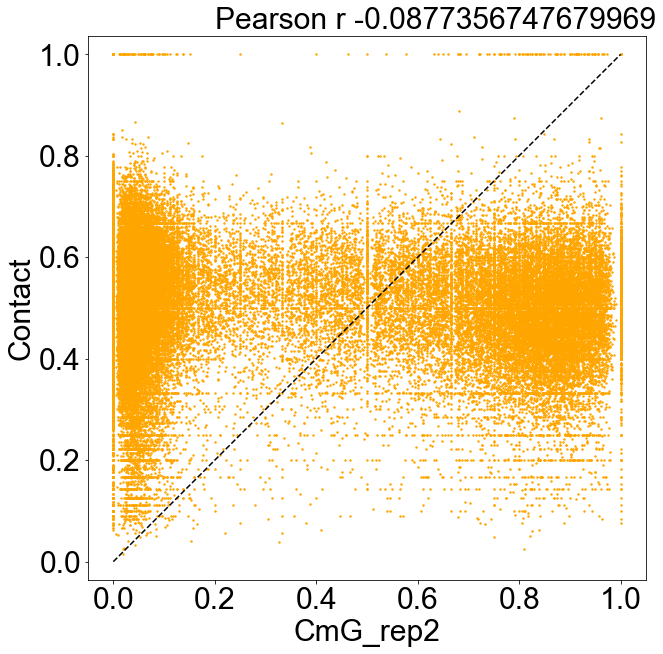

In [80]:
consistency(contact_met_order5['met'],contact_met_order5['binnor_nor'],'CmG_rep2','Contact','order5')